# Pyisical Activity Monitoring

This notebook will serve as a reference on how to use phyisical activity monitoring algortihm.

The example illustrates how the physical activity monitoring (PHAM) algorithm is used to determine the intensity level of sedentary, light, moderate, and vigorous physical activities using body acceleration recorded with a triaxial accelerometer worn on the wrist. The physical activity monitoring algorithm is implemented in the main module `NGMT\ngmt\modules\PHAM.py`.

The algorithm determines the intensity level of the physical activities based on the following steps. It starts by loading the input_data, which includes data with a time index along with accelerometer data (N, 3) for x, y, and z axes. The other input of the algorithm is sampling_frequency, which is in Hz, and the default value is 100. Another input of the algorithm is thresholds, which should be provided as a dictionary containing threshold values for physical activity detection. Epoch length, which is defined in seconds, is the next input of the algorithm, as shown with epoch_duration. The default value is 5 seconds. The last input of the algorithm is plot_results, which, if set to True, generates a plot showing the average Euclidean Norm Minus One (ENMO) per hour for each date. The default is True.

The following steps are taken to preprocess the input signal. First, the sample-level Euclidean norm (EN) of the acceleration signal across the x, y, and z axes is calculated. Next, a fourth-order Butterworth low-pass filter with a cut-off frequency of 20Hz is applied to remove noise. This filter is applied to the vector magnitude scores, rather than the individual axes. To separate out the activity-related component of the acceleration signal, the ENMO index is calculated. The Euclidean Norm Minus One (ENMO) is a summary metric for acceleration data and represents the vector magnitude of 3 axial measures minus the contribution of gravity (1 g). Then, negative values of the ENMO are truncated to zero. Finally, the calculated indices are multiplied by 1000 to convert the units of the acceleration from g to milli-g.

The algorithm continues by classifying the intensity of the physical activities based on the calculated ENMO values. Using the activity_classification function, the ENMO time-series data is then expressed in 5-second epochs. Epochs with a length of 5 seconds are used for summarizing the data, as this epoch length has been suggested to be able to capture shorter bouts of activities. The greater the intensity of movement and duration of activity in the summed 5-second epochs are, the greater the ENMO value is. Then, the intensity of activities as the time distribution of ENMO using 5-second epochs is used to classify activities based on different thresholds. In the analysis of intensity distribution, the following thresholds are used for categorization: sedentary activity < 45 milli-g, light activity 45–100 milli-g, moderate activity 100–400 milli-g, vigorous activity > 400 milli-g.

Finally, the algorithm takes the last steps to classify different levels of activities along with the time spent on each activity level for each day. The algorithm also visualizes the averaged ENMO values for each day.


## Import libraries
The necessary libraries such as pandas, os and physical activity monitoring (PHAM) are imported. Make sure that you have all the required libraries and modules installed before running this code. You also may need to install the 'ngmt' library and its dependencies if you haven't already.

In [1]:
import pandas as pd
import numpy as np
from ngmt.modules import PHAM
import os

## Load Data
The data, including time index and accelerometer data (N, 3) for the x, y, and z axes, is loaded as a numpy.ndarray.

In [2]:
# This code snippet loads motion data from a csv file.
# The data importer for fair-park data will be added.
# The 'data_folder_path' variable holds the absolute path to the data file
data_folder_path = r'C:\Users\Project\Desktop\sub_001'

# Create an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Iterate over all CSV files in the folder for each subject
for file_name in os.listdir(data_folder_path):
    # Check if the file is a CSV file and has the expected prefix
    if file_name.endswith(".csv") and file_name.startswith("sub-001_imu-LARM_"):
        # Construct the full path to the CSV file
        file_path = os.path.join(data_folder_path, file_name)
        
        # Read the CSV file into a DataFrame
        current_data = pd.read_csv(file_path, header=None, sep=';')

        # Rename columns and convert time columns to datetime format
        current_data.columns = ['Acc_x', 'Acc_y', 'Acc_z', 'Gyr_x', 'Gyr_y', 'Gyr_z', 'Mag_x', 'Mag_y', 'Mag_z', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']
        current_data['time'] = pd.to_datetime(current_data[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']], format='%Y-%m-%d %H:%M:%S')
        current_data.set_index('time', inplace=True)

        # Select accelerometer columns and convert units from m/s^2 to g
        current_data = current_data[["Acc_x", "Acc_y", "Acc_z"]].copy()
        current_data[['Acc_x', 'Acc_y', 'Acc_z']] /= 9.81

        # Concatenate the current data with the combined data
        combined_data = pd.concat([combined_data, current_data])

# Sampling frequency
sampling_frequency = 100

## Apply the physical activity monitoring algorithm
Now, we are running physical activity monitoring (PHAM) algorithm from main module (`NGMT.ngmt.modules.PHAM.Physical_Activity_Monitoring`). The inputs of the algorihm are as follows. The input_data, includes data with a time index along with accelerometer data (N, 3) for x, y, and z axes. The sampling_frequency is the sampling frequecy of the acceleration data which is defined in Hz, and the default value of it is 100 Hz. The next input, thresholds, are provided as a dictionary containing threshold values for physical activity detection. The epoch_duration is the epoch length in seconds and the default value is 5 seconds. The last input of the algorithm is plot_results, which, if set to True, generates a plot showing the average Euclidean Norm Minus One (ENMO) per hour for each day. The default is True.




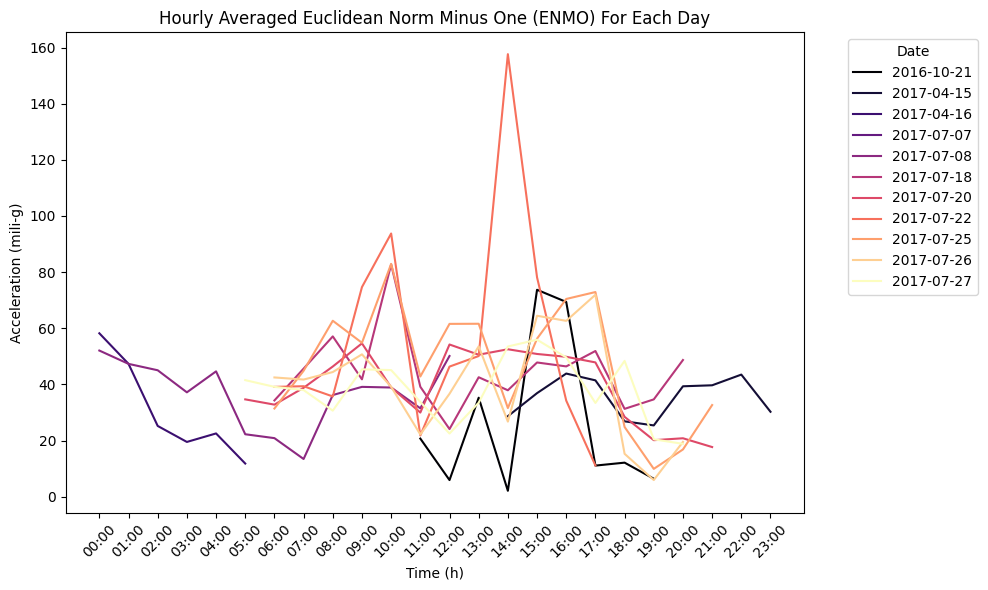

In [3]:

# Use Physical_Activity_Monitoring to classify physical activity levels
phyam_results = PHAM.Physical_Activity_Monitoring(input_data=combined_data, sampling_frequency=100, thresholds={'sedentary_threshold': 45, 'light_threshold': 100, 'moderate_threshold':400}, epoch_duration=5, plot_results=True)


In [4]:
# Display average ENMO values for each activity levels for each day.
for index, row in phyam_results.iterrows():
    print(f"Date: {row['date']}")
    
    # Check if there are NaN values for mean acceleration
    if not np.isnan(row['sedentary_mean_acc']):
        print(f"Mean ENMO for Sedentary: {row['sedentary_mean_acc']} mili-g")
        print(f"Time Spent for Sedentary: {row['sedentary_spent_time_minute']} minutes")
    
    if not np.isnan(row['light_mean_acc']):
        print(f"Mean ENMO for Light Activity: {row['light_mean_acc']} mili-g")
        print(f"Time Spent for Light Activity: {row['light_spent_time_minute']} minutes")
    
    if not np.isnan(row['moderate_mean_acc']):
        print(f"Mean ENMO for Moderate Activity: {row['moderate_mean_acc']} mili-g")
        print(f"Time Spent for Moderate Activity: {row['moderate_spent_time_minute']} minutes")
    
    if not np.isnan(row['vigorous_mean_acc']):
        print(f"Mean ENMO for Vigorous Activity: {row['vigorous_mean_acc']} mili-g")
        print(f"Time Spent for Vigorous Activity: {row['vigorous_spent_time_minute']} minutes")
    
    print("=" * 40)

Date: 2016-10-21
Mean ENMO for Sedentary: 5.315398506372166 mili-g
Time Spent for Sedentary: 338.41666666666663 minutes
Mean ENMO for Light Activity: 69.80800287441187 mili-g
Time Spent for Light Activity: 145.16666666666666 minutes
Mean ENMO for Moderate Activity: 119.97283014741834 mili-g
Time Spent for Moderate Activity: 15.083333333333332 minutes
Date: 2016-10-22
Date: 2016-10-23
Date: 2016-10-24
Date: 2016-10-25
Date: 2016-10-26
Date: 2016-10-27
Date: 2016-10-28
Date: 2016-10-29
Date: 2016-10-30
Date: 2016-10-31
Date: 2016-11-01
Date: 2016-11-02
Date: 2016-11-03
Date: 2016-11-04
Date: 2016-11-05
Date: 2016-11-06
Date: 2016-11-07
Date: 2016-11-08
Date: 2016-11-09
Date: 2016-11-10
Date: 2016-11-11
Date: 2016-11-12
Date: 2016-11-13
Date: 2016-11-14
Date: 2016-11-15
Date: 2016-11-16
Date: 2016-11-17
Date: 2016-11-18
Date: 2016-11-19
Date: 2016-11-20
Date: 2016-11-21
Date: 2016-11-22
Date: 2016-11-23
Date: 2016-11-24
Date: 2016-11-25
Date: 2016-11-26
Date: 2016-11-27
Date: 2016-11-28
D